##                  WINE QUALITY PREDICTION

In [7]:
# import necessary libraries

import pandas as pd
import sys 
import numpy as np
import seaborn as sns
from math import sqrt

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

***

**------------------------------------------------------------ 1. LOADING THE DATA -----------------------------------------------------------------**

***

In [8]:
# load wine dataset from csv
csv_path = "winedata.csv"
df = pd.read_csv(csv_path, sep = ';', error_bad_lines=False)  # dropping bad lines

b'Skipping line 3149: expected 12 fields, saw 13\nSkipping line 4821: expected 12 fields, saw 13\n'


In [9]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6
1,6.3,0.3,0.34,1.6,0.049,14.0,132.0,0.9940000000000001,3.3,0.49,9.5,6
2,8.1,0.28,0.4,6.9,0.05,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.057999999999999996,47.0,186.0,0.9956,3.19,0.4,9.9,6
4,7.2,0.23,0.32,8.5,0.057999999999999996,47.0,186.0,0.9956,3.19,0.4,9.9,6


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 12 columns):
fixed acidity           4891 non-null float64
volatile acidity        4891 non-null object
citric acid             4843 non-null object
residual sugar          4886 non-null object
chlorides               4890 non-null object
free sulfur dioxide     4888 non-null object
total sulfur dioxide    4889 non-null object
density                 4890 non-null object
pH                      4890 non-null object
sulphates               4892 non-null object
alcohol                 4890 non-null object
quality                 4892 non-null object
dtypes: float64(1), object(11)
memory usage: 459.1+ KB


In [18]:
# calculate total number of null values in dataframe
df.isnull().sum().sum()

130

In [19]:
# calculate minimum value for each column
minimum = df[['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide','density', 'pH', 'sulphates', 'alcohol']].min()
minimum

fixed acidity           3.80000
volatile acidity        0.08000
citric acid             0.00000
residual sugar          0.60000
chlorides               0.00900
free sulfur dioxide     2.00000
total sulfur dioxide    9.00000
density                 0.98711
pH                      2.72000
sulphates               0.22000
alcohol                 8.00000
dtype: float64

In [20]:
# calculate maximum value for each column
maximum = df[['fixed acidity','volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide','density', 'pH', 'sulphates', 'alcohol']].max()
maximum

fixed acidity            14.20000
volatile acidity          1.10000
citric acid               1.66000
residual sugar           65.80000
chlorides                 0.34600
free sulfur dioxide     289.00000
total sulfur dioxide    440.00000
density                   1.03898
pH                        3.82000
sulphates                 1.08000
alcohol                  14.20000
dtype: float64

scale of different attributes is not equal,for example scale of volatile acidity is 0.08-1.1 whereas for total sulphur dioxide it is 9 - 440

In [21]:
# change object type to float for all columns except quality
df[['volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide','density', 'pH', 'sulphates', 'alcohol']]= df[['volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide','density', 'pH', 'sulphates', 'alcohol']].astype('float')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 12 columns):
fixed acidity           4891 non-null float64
volatile acidity        4890 non-null float64
citric acid             4842 non-null float64
residual sugar          4885 non-null float64
chlorides               4889 non-null float64
free sulfur dioxide     4887 non-null float64
total sulfur dioxide    4888 non-null float64
density                 4889 non-null float64
pH                      4889 non-null float64
sulphates               4891 non-null float64
alcohol                 4889 non-null float64
quality                 4892 non-null object
dtypes: float64(11), object(1)
memory usage: 459.1+ KB


In [23]:
# number of unique values in every column
df.nunique()

fixed acidity            68
volatile acidity        125
citric acid              87
residual sugar          310
chlorides               160
free sulfur dioxide     132
total sulfur dioxide    251
density                 890
pH                      103
sulphates                79
alcohol                 103
quality                  11
dtype: int64

In [24]:
# calculate the number of unique wines
print(len(df.drop_duplicates()))

4013


**Observations**

In [1]:
#there are 4896 rows and 12 columns
#there are 4896 entries i.e. 4896 wines are included in the dataset
#mostly all features have object data type which should be changed to numeric
#all columns have some null entries,total = 120
#column quality has some non numeric entries such as low,high
#scale of the different attributes is not equal as attributes have varying ranges
#All wines are not unique, there are only 4013 unique wines
#scale of different attributes is not equal,for example scale of volatile acidity is 0.08-1.1 whereas for total sulphur dioxide it is 9 - 440

In [25]:
# finding minimum and maximum values of column quality
df_quality = pd.to_numeric(df['quality'],downcast='float',errors='coerce')
df_quality.describe()

count    4794.000000
mean        5.876929
std         0.884690
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

We find min = 3 & max = 9

In [26]:
# replace 'low' by 3 and 'high' by 9
df['quality'] = df['quality'].replace(to_replace = 'low', value = 3)
df['quality'] = df['quality'].replace(to_replace = 'high', value = 9)

In [27]:
# change data type of quality
df['quality'] = pd.to_numeric(df['quality'],downcast='float',errors='coerce')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 12 columns):
fixed acidity           4891 non-null float64
volatile acidity        4890 non-null float64
citric acid             4842 non-null float64
residual sugar          4885 non-null float64
chlorides               4889 non-null float64
free sulfur dioxide     4887 non-null float64
total sulfur dioxide    4888 non-null float64
density                 4889 non-null float64
pH                      4889 non-null float64
sulphates               4891 non-null float64
alcohol                 4889 non-null float64
quality                 4882 non-null float32
dtypes: float32(1), float64(11)
memory usage: 440.0 KB


In [29]:
# drop all rows that have less then 9 non-null entries to get true entries in the dataset
df = df.dropna(thresh=9)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4888 entries, 0 to 4895
Data columns (total 12 columns):
fixed acidity           4888 non-null float64
volatile acidity        4887 non-null float64
citric acid             4840 non-null float64
residual sugar          4884 non-null float64
chlorides               4887 non-null float64
free sulfur dioxide     4886 non-null float64
total sulfur dioxide    4887 non-null float64
density                 4888 non-null float64
pH                      4887 non-null float64
sulphates               4888 non-null float64
alcohol                 4888 non-null float64
quality                 4879 non-null float32
dtypes: float32(1), float64(11)
memory usage: 477.3 KB


In [31]:
#calculate mean of all the columns
df.mean()

fixed acidity             6.855043
volatile acidity          0.278266
citric acid               0.334304
residual sugar            6.396263
chlorides                 0.045780
free sulfur dioxide      35.330536
total sulfur dioxide    138.413239
density                   0.994029
pH                        3.188120
sulphates                 0.489822
alcohol                  10.514214
quality                   5.892806
dtype: float64

In [32]:
#fill null entries with the mean of entries of each column for better predicted results later
df = df.fillna(df.mean())

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4888 entries, 0 to 4895
Data columns (total 12 columns):
fixed acidity           4888 non-null float64
volatile acidity        4888 non-null float64
citric acid             4888 non-null float64
residual sugar          4888 non-null float64
chlorides               4888 non-null float64
free sulfur dioxide     4888 non-null float64
total sulfur dioxide    4888 non-null float64
density                 4888 non-null float64
pH                      4888 non-null float64
sulphates               4888 non-null float64
alcohol                 4888 non-null float64
quality                 4888 non-null float32
dtypes: float32(1), float64(11)
memory usage: 477.3 KB


In [34]:
print(len(df.drop_duplicates()))

4008


There are 4008 unique wines after data cleaning.
There are 4888 non-null entries in each column after initial data cleaning.

***

**--------------------------------------------------- 2. VISUALIZING THE DATA ------------------------------------------------------**

***

/Users/ankita/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


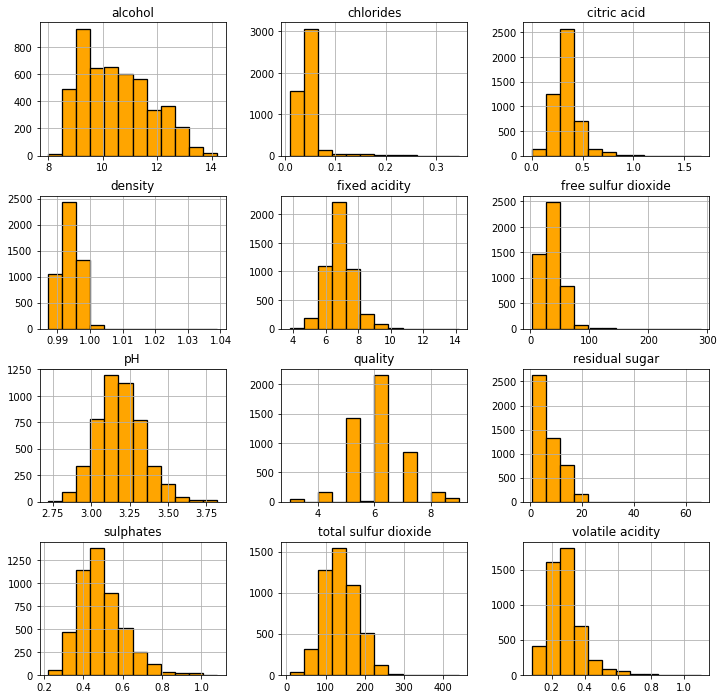

In [35]:
#plot frequency histograms of each attribute in the data set
#x axis:values, y axis:frequency

fig = plt.figure(figsize = (12,12))
ax = fig.gca()
df.hist(ax=ax,edgecolor='black',facecolor='orange',bins=12,linewidth = 1.3)
plt.show()

### Observations

- Rightskewed: assymetrical distribution,as value increases frequency increases at first,then unsymmetrically decreases
- Normal: symmetrical distribution,first frequency increases till middle value is reached then symmetrically frequency decreases


In [ ]:
#alcohol             - right skewed distribution
#chloride            - right skewed distribution
#citric acid         - right skewed distribution
#density             - normal distribution
#fixed acidity       - normal distribution
#free sulfur dioxide - right skewed distribution
#pH                  - normal distribution
#quality             - normal distribution
#residual sugar      - right skewed distribution
#sulphates           - right skewed distribution
#total sulfur dioxide-normal distribution
#volatile acidity    -right skewed distribution

In [36]:
correlation = df.corr()['quality'].drop('quality')
correlation

fixed acidity          -0.101936
volatile acidity       -0.184536
citric acid            -0.005667
residual sugar         -0.088719
chlorides              -0.201222
free sulfur dioxide     0.005698
total sulfur dioxide   -0.161287
density                -0.289161
pH                      0.089115
sulphates               0.049302
alcohol                 0.414487
Name: quality, dtype: float64

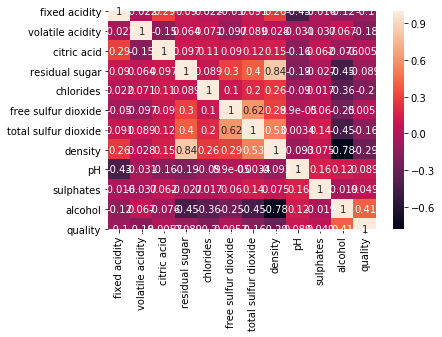

In [37]:
#plot a heatmap between correlations
sns.heatmap(df.corr(), annot=True)
plt.show()

In [38]:
abs(correlation) >= 0.2

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides                True
free sulfur dioxide     False
total sulfur dioxide    False
density                  True
pH                      False
sulphates               False
alcohol                  True
Name: quality, dtype: bool

#### chlorides,density,alcohol most correlated to quality of wine
- corr with chloride = -0.201222
- corr with density  = -0.289161
- corr with alcohol  =  0.414487

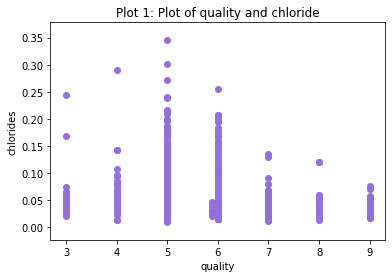

In [39]:
plt.scatter('quality','chlorides', data=df,color='mediumpurple')
plt.xlabel("quality")
plt.ylabel("chlorides")
plt.title("Plot 1: Plot of quality and chloride")
plt.show()

### Observation
#### Plot 1
- First there is a some positive relationship between quality of wine and alcohol 
- After quality is 5 there is a downward slope so there is a negative relationship between the two variables
- Most wines with high chlorides have a quality of 5
- When cloride content is low,quality is high
- wines have chlorides content ranging from ~0.01 to 0.36

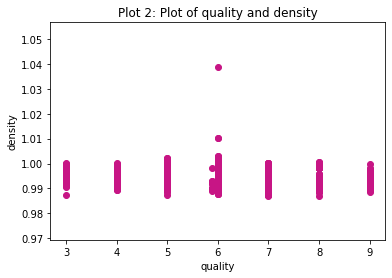

In [40]:
plt.scatter('quality','density', data=df,color='mediumvioletred')
plt.xlabel("quality")
plt.ylabel("density")
plt.title("Plot 2: Plot of quality and density")
plt.show()

### Observation
#### Plot 2
- Density of most wines lies between ~0.99 to 1.01 
- Wines with high density have a quality of 6
- There is a negative relationship between the density and quality
- When density is low,quality is high

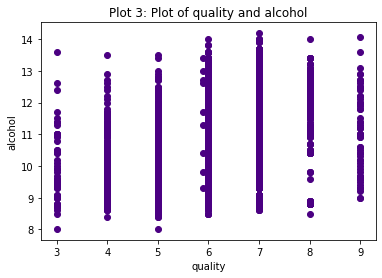

In [41]:
plt.scatter('quality','alcohol', data=df,color='indigo')
plt.xlabel("quality")
plt.ylabel("alcohol")
plt.title("Plot 3: Plot of quality and alcohol")
plt.show()

### Observation
#### Plot 3
- As alcohol content increases,quality of wine increases
- There is a positive relationship between quality of wine and alcohol,when alcohol content increases,quality of wine increases
- Wines have alcohol content ranging from ~7 to 15

***

**---------------------------------------------------------------- 3. TRAIN TEST SPLIT --------------------------------------------------------------**

***

In [42]:
#splitting data into training and testing sets, 20% of the data is test data, and remaining 80% is training data
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

X_train = train_set.drop(["quality"], axis=1)   # training features
y_train = train_set["quality"].copy()           # training label
X_test = test_set.drop(["quality"], axis=1)     # testing features
y_test =  test_set["quality"].copy()            # testing label

In [43]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3910, 11) (3910,)
(978, 11) (978,)


In [57]:
#calculate median of quality 
median_quality = y_train.median()
median_quality

6.0

In [58]:
print("rmse value: ",np.sqrt(np.mean((y_train - y_train.median())**2)))

rmse value:  0.9725258061826707


- Rmse when median quality value is the predictor is 0.97252584

- Regression and classification are categorised under supervised machine-learning and Classification is the method of predicting a discrete class label

- Regression predictions can be evaluated using root mean squared error while classification predictions cannot

- We should use regression here because the variable quality which we want to predict is a continous variable

***

**----------------------------------------- 4. DATA MODELLING AND VISUALISING ACTUAL AND PREDICTED DATA ----------------------------------------**

***

#### 1. LINEAR REGRESSION MODEL

In [46]:
import sklearn
from sklearn.linear_model import LinearRegression

reg = linear_model.LinearRegression()
model1 = reg.fit(X_train,y_train)
reg.coef_

array([ 8.87288939e-02, -1.99690251e+00,  3.17647318e-02,  9.16409136e-02,
        3.74002225e-01,  3.10229001e-03,  1.71813594e-04, -1.68247214e+02,
        7.20829463e-01,  6.92319365e-01,  1.94864263e-01])

In [60]:
#predict value of quality on the training set
y1_pred = reg.predict(X_train)

#caculate root mean square error
rmse1 = np.sqrt(metrics.mean_squared_error(y1_pred,y_train))
rmse1

0.8370730990199982

In [61]:
df_lin = pd.DataFrame({'Actual': y_train, 'Predicted': y1_pred})
df_lin.head()

,Actual,Predicted
4003,7.0,6.364437
2618,7.0,6.243907
3091,6.0,5.822468
3981,7.0,6.667679
4052,7.0,5.644099


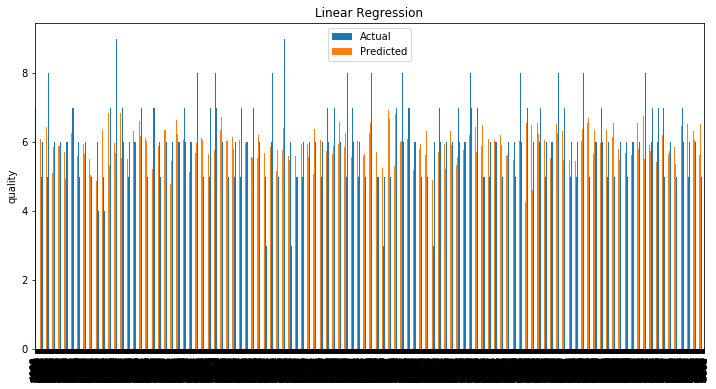

In [58]:
#plot of true values and predicted values
df_lin.plot(kind='bar',figsize=(12,6))
plt.ylabel('quality')
plt.title("Linear Regression")
plt.show()

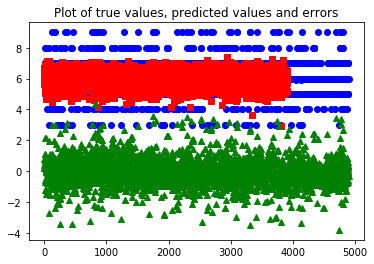

In [62]:
#plot of true values, predicted values and errors#

#let true value be representes as blue dots
plt.plot(y_train,'bo')

#let predicted value be represented as red squares
plt.plot(y1_pred,'rs')

#let error value be represented as green triangles
plt.plot(y_train-y1_pred,'g^')

plt.title("Plot of true values, predicted values and errors")
plt.show()

#### 2. K-NEAREST NEIGHBOUR REGRESSION MODEL


In [63]:
from sklearn.neighbors import KNeighborsRegressor

# N = 5 #
neigh = KNeighborsRegressor(n_neighbors = 5)
neigh.fit(X_train,y_train)

#predict value of quality on the training set
y2_pred = neigh.predict(X_train)

#caculate root mean square error
rmse2 = sqrt(mean_squared_error(y2_pred,y_train))
rmse2

0.7341590726230895

In [64]:
# N = 7 #
neigh1 = KNeighborsRegressor(n_neighbors = 7)
neigh1.fit(X_train,y_train)

#predict value of quality on the training set
y3_pred = neigh1.predict(X_train)

#caculate root mean square error
sqrt(mean_squared_error(y3_pred,y_train))

0.7703015881862361

In [65]:
# N = 10 #
neigh2 = KNeighborsRegressor(n_neighbors = 10)
neigh2.fit(X_train,y_train)

#predict value of quality on the training set
y4_pred = neigh2.predict(X_train)

#caculate root mean square error
sqrt(mean_squared_error(y4_pred,y_train))

0.8028360566944415

In [66]:
# N = 15 #
neigh3 = KNeighborsRegressor(n_neighbors = 15)
neigh3.fit(X_train,y_train)

#predict value of quality on the training set
y5_pred = neigh3.predict(X_train)

#caculate root mean square error
sqrt(mean_squared_error(y5_pred,y_train))

0.8328585384733905

Note: rmse increases when values of k(no. of neighbours) increase 

In [ ]:
#plot of true values and predicted values
df_knn = pd.DataFrame({'Actual': y_train, 'Predicted': y2_pred})

df_knn.plot(kind='bar',figsize=(12,6))
plt.ylabel('quality')
plt.title("K-Nearest Neighbour")
plt.show()

In [ ]:
#plot of true values, predicted values and errors
plt.plot(y_train,'bo')
plt.plot(y2_pred,'rs')
plt.plot(y_train-y2_pred,'g^')

plt.title("Plot of true values, predicted values and errors")
plt.show()

#### 3. DESCISION TREE MODEL

In [128]:
from sklearn import tree

In [129]:
tree_regr1 = tree.DecisionTreeRegressor(max_depth = 2)
tree_regr2 = tree.DecisionTreeRegressor(max_depth = 5)

#fit the traning data to a descision tree model
tree_regr11 = tree_regr1.fit(X_train,y_train)
tree_regr12 = tree_regr2.fit(X_train,y_train)

#predict value of quality on the training set
z11 = tree_regr1.predict(X_train)
z12 = tree_regr2.predict(X_train)

In [130]:
#caculate root mean square error
rmse31 = sqrt(mean_squared_error(z11,y_train))
rmse31


0.8571428352231814

In [131]:
rmse32 = sqrt(mean_squared_error(z12,y_train))
rmse32

0.7877537186473644

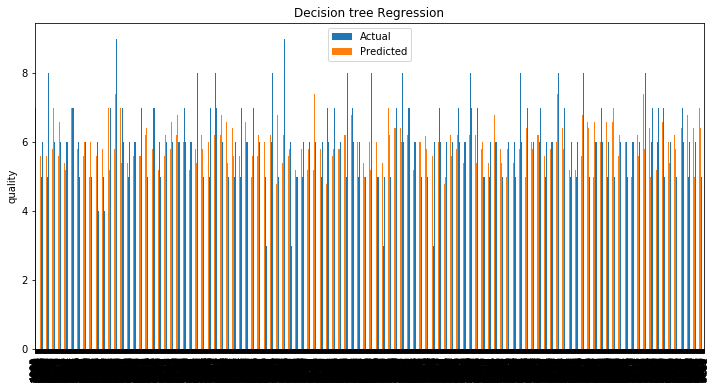

In [132]:
#plot of true values and predicted values#

df_tree = pd.DataFrame({'Actual': y_train, 'Predicted': z12})
df_knn.plot(kind='bar',figsize=(12,6))

plt.ylabel('quality')
plt.title("Decision tree Regression")
plt.show()

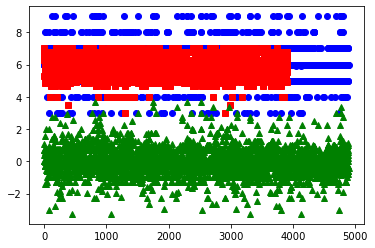

In [133]:
#plot of true values, predicted values and errors#

plt.plot(y_train,'bo')
plt.plot(z12,'rs')
plt.plot(y_train-z12,'g^')

plt.title("Plot of true values, predicted values and errors")
plt.show()

### Observations

In [2]:
# RMSE:
#rmse of linear reg                        : 0.8370730990199984
#rmse of k-nearest neighbour(lowest:k=5)   : 0.7341590726230895
#rmse of decesion tree(lowest:maxdepth=5)  : 0.7877537186473644

#Plot:
#Mostly all predicted values lie between 4 to 8 range 
#Wheras original values lie between 3 to 9 range
#Errors mostly lie between -2 to 2 range

#How errors compare:
#The lowest error is of k-nearest neighbour model and largest is of linear regression
#Neighbors regression works well in cases where the data labels are continuous rather than discrete
#k-nearest neighbour might perform better for the test set


***

**-------------------------------------------------------------------- 5. CROSS VALIDATION ----------------------------------------------------------------**

***

##### CROSS VALIDATION
- done to avoid underfitting/overfitting of data and to get a better understanging of how good our models are performing
- split  data into k subsets, and train on k-1 of those subset,leaving one for testing
- performing 10-fold cross validation for each model#

#### 1 LINEAR REGRESSION MODEL

In [60]:
clf1 = LinearRegression()

#calculating cross validation score with scoring set to negative mean absolute error
scores_1 = cross_val_score(clf1, X_train,y_train, cv=10,scoring='neg_mean_absolute_error')
scores_1

array([-0.61778693, -0.59314161, -0.63525385, -0.67418737, -0.6016719 ,
       -0.66572714, -0.62824801, -0.63266254, -0.61708604, -0.62818339])

In [61]:
#calculating absolute value
scores_lin = -scores_1
scores_lin

array([0.61778693, 0.59314161, 0.63525385, 0.67418737, 0.6016719 ,
       0.66572714, 0.62824801, 0.63266254, 0.61708604, 0.62818339])

In [62]:
#calculate mean of scores for better understanding the accuracy
mean1 = np.mean(scores_lin)
mean1

0.6293948781847534

#### 2 K-NEAREST NEIGHBOUR REGRESSION MODEL

In [ ]:
clf2 = neigh2

#calculating cross validation score with scoring set to negative mean absolute error
scores_2 = cross_val_score(clf2, X_train, y_train, cv=10,scoring='neg_mean_absolute_error')
scores_2

In [85]:
#calculating absolute value
scores_k = -scores_2

In [86]:
#calculate mean of scores for better understanding the accuracy
mean2 = np.mean(scores_k)
mean2

0.6846538484096527

#### 3 DESCISION TREE MODEL

In [90]:
clf3 = tree_regr2

#calculating cross validation score with scoring set to negative mean absolute error
scores_3 = cross_val_score(clf3, X_train, y_train, cv=10,scoring='neg_mean_absolute_error')
scores_3

array([-0.59816286, -0.5839611 , -0.62032227, -0.68073531, -0.62030119,
       -0.63890088, -0.62707998, -0.61277456, -0.62866451, -0.63058695])

In [91]:
#calculating absolute value
scores_tree = -scores_3

In [92]:
#calculate mean of scores for better understanding the accuracy
mean3 = np.mean(scores_tree)
mean3

0.6241489592100825

### Observation

In [ ]:

#cv score for linear                  : 0.6293948781847534
#cv score for k-nearest neighbour     : 0.6846538484096527
#cv score for decision tree           : 0.6241489592100825

#rmse of linear reg                        : 0.8370730990199984
#rmse of k-nearest neighbour(lowest:k=5)   : 0.7341590726230895
#rmse of decesion tree(lowest:maxdepth=5)  : 0.7877537186473644

#BEST MODEL: Decision Tree based on cv score
#because it has the lowest mean absolute error of 0.62414

***

**----------------------------------------------------------- 6. SCALING AND FINAL MODEL -----------------------------------------------------------------------**

***

In [95]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


#### Pre-processing: Scaling the data

In [96]:
scaler = MinMaxScaler()

scaler = preprocessing.MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)

In [97]:
X_train_minmax

array([[0.32911392, 0.29411765, 0.15662651, ..., 0.30909091, 0.3255814 ,
        0.71666667],
       [0.34177215, 0.17647059, 0.12650602, ..., 0.45454545, 0.18604651,
        0.55      ],
       [0.30379747, 0.19607843, 0.28313253, ..., 0.36363636, 0.3372093 ,
        0.25      ],
       ...,
       [0.35443038, 0.05882353, 0.30722892, ..., 0.17272727, 0.37209302,
        0.45      ],
       [0.44303797, 0.16666667, 0.1746988 , ..., 0.37272727, 0.08139535,
        0.46666667],
       [0.11392405, 0.25490196, 0.        , ..., 0.58181818, 0.45348837,
        0.31666667]])

#### We will find rmse and mean absolute error with scaled data

**LINEAR REGRESSION**

In [274]:
reg_l = reg
reg_l.fit(X_train_minmax,y_train)
y00_pred = reg_l.predict(X_train_minmax)

#sqrt(mean_squared_error(x,training_labels))
np.sqrt(metrics.mean_squared_error(y00_pred,y_train))

0.8370730990199979

In [99]:
cvs0 = reg_l

#calculating cross validation score with scoring set to negative mean absolute error
scores_n0 = cross_val_score(cvs0, X_train_minmax,y_train, cv=10,scoring='neg_mean_absolute_error')
scores_n0

array([-0.61778693, -0.59314161, -0.63525385, -0.67418737, -0.6016719 ,
       -0.66572714, -0.62824801, -0.63266254, -0.61708604, -0.62818339])

In [100]:
scores_n0_pos = -scores_n0
np.mean(scores_n0_pos)

0.6293948781847546

**K-NEAREST NEIGHBOUR**

In [144]:
reg_n = neigh2
reg_n.fit(X_train_minmax,y_train)

y11_pred = reg_n.predict(X_train_minmax)

np.sqrt(metrics.mean_squared_error(y11_pred,y_train))

0.72907424

In [145]:
cvs1 = reg_n

#calculating cross validation score with scoring set to negative mean absolute error
scores_n1 = cross_val_score(cvs1, X_train_minmax,y_train, cv=10,scoring='neg_mean_absolute_error')
scores_n1

array([-0.59349644, -0.60633904, -0.61101586, -0.63639033, -0.56741852,
       -0.61868846, -0.5754934 , -0.59391671, -0.59718668, -0.61386555])

In [146]:
scores_n1_pos = -scores_n1
np.mean(scores_n1_pos)

0.6013810992240906

**DECISION TREE**

In [250]:
reg_tree = tree_regr2
reg_tree.fit(X_train_minmax,y_train)

y22_pred = reg_tree.predict(X_train_minmax)

np.sqrt(metrics.mean_squared_error(y22_pred,y_train))

0.7877537186473644

In [251]:
cvs1 = reg_tree
#calculating cross validation score with scoring set to negative mean absolute error
scores_n2 = cross_val_score(cvs1, X_train_minmax,y_train, cv=10,scoring='neg_mean_absolute_error')
scores_n2

array([-0.59680677, -0.5839611 , -0.62032227, -0.68073531, -0.62030119,
       -0.63946354, -0.62707998, -0.61277456, -0.62866451, -0.63058695])

In [252]:
scores_n2_pos = -scores_n2
np.mean(scores_n2_pos)

0.6240696158448296

try another model: 
##### BAYESIAN RIDGE REGRESSION

In [253]:
from sklearn import linear_model

breg = linear_model.BayesianRidge()
breg.fit(X_train_minmax,y_train)
#BayesianRidge()

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [111]:
#predict value of quality on the training set
y_pred = breg.predict(X_train_minmax)

#caculate root mean square error
rmse_b = np.sqrt(metrics.mean_squared_error(y_pred,y_train))
rmse_b

0.8372990633746291

In [112]:
clfb = breg

#calculating cross validation score with scoring set to negative mean absolute error
scores_b = cross_val_score(clfb, X_train_minmax,y_train, cv=10,scoring='neg_mean_absolute_error')
scores_b

array([-0.61769851, -0.59409727, -0.63825235, -0.67624179, -0.60070178,
       -0.66483503, -0.62848181, -0.63298682, -0.61719403, -0.62546705])

In [190]:
clfbay = -scores_b
np.mean(clfbay)

0.6295956427830008

##### Note: Lowest mean absolute error is of  K-nearest neighbour
We will try to tune that then apply to test data

In [269]:
# N = 9 #
neigh_final = KNeighborsRegressor(n_neighbors = 9, weights='uniform',algorithm='kd_tree',leaf_size=31,p=2)
neigh_final.fit(X_train_minmax,y_train)

#predict value of quality on the training set
yf_pred = neigh_final.predict(X_train_minmax)

#caculate root mean square error
sqrt(mean_squared_error(yf_pred,y_train))

0.7188529065311849

In [270]:
cvs_f = neigh_final

#calculating cross validation score with scoring set to negative mean absolute error
scores_f = cross_val_score(cvs_f, X_train_minmax,y_train, cv=10,scoring='neg_mean_absolute_error')
scores_f

array([-0.59467983, -0.6046868 , -0.61784005, -0.63656491, -0.56374562,
       -0.62175757, -0.575468  , -0.59517729, -0.59704459, -0.61785012])

In [271]:
scores_f_pos = -scores_f
np.mean(scores_f_pos)

0.6024814784526825

In [272]:
X_test_minmax = scaler.fit_transform(X_test)
y_final_pred = neigh_final.predict(X_test_minmax)
y_final_pred 

array([6.111111 , 4.888889 , 5.5555553, 5.4444447, 5.6666665, 5.7777777,
       5.3333335, 5.5555553, 5.4444447, 5.2222223, 5.6666665, 5.5555553,
       5.6666665, 6.2222223, 5.7777777, 5.4444447, 5.2222223, 5.7777777,
       5.4444447, 5.5555553, 5.5555553, 5.6666665, 4.888889 , 5.3333335,
       5.4444447, 5.5555553, 7.111111 , 5.7777777, 5.6666665, 5.5555553,
       5.5555553, 7.111111 , 6.3333335, 5.2222223, 7.       , 5.3333335,
       5.3333335, 5.6666665, 6.5555553, 5.5555553, 5.2222223, 5.5555553,
       6.6666665, 4.5555553, 5.111111 , 5.5555553, 6.888889 , 6.0992007,
       5.7777777, 5.7777777, 6.111111 , 5.888889 , 5.4444447, 5.888889 ,
       6.4444447, 6.888889 , 6.6666665, 5.888889 , 5.4444447, 5.3333335,
       6.6666665, 5.2222223, 7.111111 , 6.111111 , 5.4444447, 5.5555553,
       6.5555553, 6.2222223, 5.4444447, 7.4444447, 5.6666665, 5.3333335,
       6.888889 , 5.6666665, 5.8769784, 5.6666665, 6.       , 5.111111 ,
       5.4444447, 6.5555553, 5.3333335, 5.2222223, 

In [273]:
rmse_final = np.sqrt(metrics.mean_squared_error(y_final_pred ,y_test))
rmse_final

0.8749431